# PIA - Reinforcement Learning

1. RL Intro
2. **Dynamic Programing**
3. Tabular Q-Learning
4. Deep Reinforcement Learning (DQN)

## 2. Dynamic Programming

In this notebook you will implement a first solution method for the gridworld maze with Dynamic Programming. More precisely you will implement the Value Iteration algorithm and learn more about its central concept, the value function. Understanding the benefits and shortcommings of this approach is key to better understand all other RL algorithms, their solutions and trade-offs. 

---
### Course of Action

* Please write all executable python code in ```Code```-Cells (```Cell```->```Cell Type```->```Code```) and all Text as [Markdown](http://commonmark.org/help/) in ```Markdown```-Cells
* Describe your thinking and your decisions (where appropriate) in an extra Markdown Cell or via Python comments
* In general: discuss all your results and comment on them (are they good/bad/unexpected, could they be improved, how?, etc.). Furthermore, visualise your data (input and output).
* Write a short general conclusion at the end of the notebook
* Further experiments are encouraged. However, don't forget to comment on your reasoning.
* Use a scientific approach for all experiments (i.e. develop a hypothesis or concrete question, make observations, evaluate results)

### Submission

E-Mail your complete Notebook to [maucher@hdm-stuttgart.de](mailto:maucher@hdm-stuttgart.de) until the start of the next lecture. One Notebook per Group is enough. Edit the teammember table below.

**Important**: Also attach a HTML version of your notebook (```File```->```Download as```->```HTML```) in addition to the ```.ipynb```-File.

| Teammember |                    |
|------------|--------------------|
| 1.         | Patrick Singer     |
| 2.         | Milos Aleksic      |



<font color="blue"><b>For better differentiation, all added comments from us will be marked in blue color.</b></font>


## Prerequisites

- The notebook is pretty self contained and includes all relevant theory. However, make sure that you have **read** and *understood* a corresponding lecture at least once! The notebook can only provide a short recap. Being prepared will help you to finish the notebook in time!
- Some good reading resources are:

    1. Johannes Maucher's [lecture on RL](https://gitlab.mi.hdm-stuttgart.de/maucher/ML/tree/master/Slides/V12Reinforcement.pdf) - chapter 2 & 3.
    2. David Silver's course on RL: [Lecture 2](https://www.davidsilver.uk/teaching/): [Youtube](https://www.youtube.com/watch?v=lfHX2hHRMVQ), [Lecture 3](https://www.davidsilver.uk/teaching/): [Youtube](https://www.youtube.com/watch?v=Nd1-UUMVfz4).
    3. Sutton & Barto: [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) chapter 4 (complete online pdf draft available).

### Welcome back!

By now, you should be familiar with our little gridworld game and how to use it in an **agent-environment loop**. As a side effect you should have gathered vital knowledge about the environment dynamics e.g. the effect of actions and how rewards are emitted. Next, you will use this knowledge to implement a first solution method with **Dynamic Programming (DP)**.

> Why can't we just skip this and proceed to DQN?
>
> #### From *Reinforcement Learning: An Introduction* - Chapter 4: Dynamic Programming
>
> "DP provides an essential foundation for the understanding of the methods presented in the rest of this book. In fact, all of these methods can be viewed as attempts to achieve much the same effect as DP, only with less computation and without assuming a perfect model of the environment."

### Markov Decision Process

Great, now that we have "convinced" you that DP is worth studying :D , let us recap everything so far but this time a bit more formally. As mentioned earlier, our gridworld problem can be described as a **Markov Decision Process (MDP)**. Formally, a MDP is a 5-tuple $\big \langle \mathcal{S,A,P,R,\gamma}  \big \rangle$, where

* $\mathcal{S}$ - is a finite set of **states**.
* $\mathcal{A}$ - is a finite set of **actions**.
* $\mathcal{P}$ - are the **state transition probabilities**. These define the dynamics of our environment which can be stochastic or deterministic.
* $\mathcal{R}$ - is the **reward function**. It determines how much reward is given for a specific (action, state transition) pair. Again, this can be stochastic or deterministic.
* $\mathcal{\gamma}$ - is a discount factor $0 \leq \gamma \leq 1$ that helps us to model the importance of short term vs. long term reward. Most commonly $\gamma = 0.9$.

Furthermore, **time** is modeled as discrete timesteps $t = 1,2,3,\ldots$. If there exists a timestep $T < \infty$ in which the environment reaches a **terminal state**  $S_T$, then the system is called **episodic MDP**. This stands in contrast to the **continuous** case where no such naturally occuring state exists. A similar distinction can be made for the state and action space. When you read something like *"Continuous control for Deep Reinforcement Learning"*, the authors typically refer to a continuous state or action space and not the time.

### Gridworld MDP
Let us make this more concrete by applying the MDP framework to our gridworld problem.

In [216]:
from gridworlds import exitgames
game, ui    = exitgames.make_game(level=0), exitgames.get_notebook_ui()
obs, rew, _ = game.its_showtime()

game.print_action_meanings()
ui.render(obs, "COLOR")

{0: 'NORTH', 1: 'SOUTH', 2: 'WEST', 3: 'EAST', 4: 'STAY'}


In the case of `exitgames.make_game(level=0)`:

* we have $4 \times 4$ discrete states $s \in \mathcal{S}$.
* we have $5$ discrete actions  $a \in \mathcal{A} = \big\{NORTH,SOUTH,WEST,EAST,STAY\big\}$.
* $\mathcal{P}(s,a)$ will produce a next state $s'$ whereby every action will succeed with probability $\mathbb{P} = 1$.  
* $\mathcal{R}(s,a,s')$ will produce a reward $r \in \{-1,0,1\}$ with probability $\mathbb{P} = 1$. 

Because every action will result in the desired next state and every reward will be emitted with probability 1, our gridworld is a **deterministic MDP**. Because the sets of actions, states and possible rewards are finite, the systems is a **finite MDP**. Finally, the *exit* square depicts a terminal state from where no further improvement is possible, hence our exitgame is an **episodic MDP**.

> It is always good to formalize your problem in this way! Even though your knowledge about the environment is typically much more limited (or the environment is much more complex), it helps you to understand its basic properties and gives you a first estimate of its complexity. In consequence, it helps you to make informed decisions about the family of algorithms you want/have to apply.

### Policies and Value Functions

Now before we start implementing our first solution, let us quickly recap two more concepts that are central to all algorithms we discuss in this lab. 

##### The Policy
The first one is the so called **policy** $\pi$. It is basically a mapping from states to actions and **fully describes the behavior of an agent**. In the most simple, deterministic case this can be written as $\pi_t(s) = a$. Think of a list of rules that literally is holding a state -> action pair for every state. More common in reinforcement learning is the usage of a **stochastic policy** which defines **the probability of choosing a distinct action $a$ given a state $s$**. Think of the random agent you just implemented. In every state the agent has chosen an action according to a **discrete uniform distribution** whereby every action is equally likely to be picked. Formally such policies are defined as

$$\pi_t(a \mid s) = \mathbb{P}\big[A_t = a \mid S_t = s\big]$$

For the discrete case, this can again be implemented as a simple list but now, holding the probabilites for every action in every state. 


#####  Value Functions
The second concept is the so called **value function** $V$. The idea is simple, $V(s)$ tells us *how good* it is to be in a given state $s$. More precisely, it tells us **how much future reward we can expect** when starting from that specific state. The amount of future reward obviously depends on the policy which the agent is following, so formally we write $V_{\pi}(s)$. In summary,

> $V_{\pi}(s)$ tells us how much reward we can expect when starting in state $s$ and following policy $\pi$ thereafter.

Because $V$ assigns values only to states, it is called the **state-value function**. Later we will also use the so called **action-value function** $Q(s,a)$ which estimates the future reward for every state-action pair separately. In other words,

> $Q_{\pi}(s,a)$ tells us how much reward we can expect when starting in state $s$, taking action $a$ and following policy $\pi$ thereafter.

### Gridworld Policy and Value Function

Again, let us make this more concrete for our little gridworld.

First, create a state-value function `V` in the form of an $n \times n$ dimensional numpy array and **initialize it with zeros**. We will use this kind of table to store and update all state values. The states itself are now implicitly described by the array indices. So the "first" state would be something like `row, col = 0, 0` and the value for that state can be retrieved by *calling* the value function `V[row,col]`, i.e. make an array lookup at this index. Now create and plot this thing with the code below.

In [217]:
import numpy as np
import seaborn as sns

def plot_value_function(V, print_values=True):
    ax = sns.heatmap(V, vmin=-1.5, vmax=1.5, annot=print_values, 
                        xticklabels=True, yticklabels=True, 
                        square=True, linewidths=.5,  
                        cmap=sns.diverging_palette(10, 220, sep=40, n=256))
    return ax

In [218]:
n_H = game.state_space[0]

n_H

4

In [219]:
n_W = game.state_space[1]

n_W

4

In [220]:
V = np.zeros((n_H, n_W))

In [221]:
V.shape

(4, 4)

In [222]:
print(V)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


<Axes: >

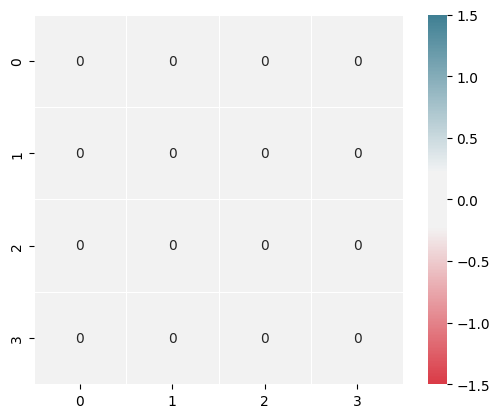

In [223]:
plot_value_function(V)

Second, create a policy `Pi` in the form of an $n \times n \times a$ dimensional numpy array. Here $a$ should be the number of actions. For simplicity, initialize the array with zeros again. In this case, the indices now refer to state followed by the action and the numbering of actions corresponds to the output of `game.get_action_set()`. So, the probability for taking action `0` in the "first" state can be retrieved by calling `Pi[0,0,0]`.

Now think about our current value function. With the knowledge that we have so far, what kind of policy would you reccomend based on the current state values? You can use `Pi.fill()` to set a value for every entry in the array at once.

In [224]:
a = len(game.get_action_set())

a

5

In [225]:
Pi = np.zeros((n_H, n_W, a))

In [226]:
Pi.shape

(4, 4, 5)

In [227]:
print(Pi)

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]


In [228]:
equal_probability = 1 / a


In [229]:
Pi.fill(equal_probability)

In [230]:
print(Pi)

[[[0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]]

 [[0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]]

 [[0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]]

 [[0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2]]]


Plotting the policy is not as straight forward as it was for the value function. However, here is a function that you can use to plot the policy as little arrows on top of the value function. Remember that our actions are essentially vectors like `(-1, 0), (1, 0)` etc.? The code bellow will just use this representation to plot corresponding arrow directions. Now go ahead and visualize your policy.

In [231]:
def plot_policy(V, Pi, action_set):
    # plot the value funtion as a background
    ax = plot_value_function(V, print_values=False)
    
    # plot every action in a quiver arrow plot
    num_rows, num_cols, num_actions = Pi.shape   
    for row in range(num_rows):
        for col in range(num_cols):
            for action in range(num_actions):
                probability = Pi[row,col,action]

                if probability: # if not zero
                    # Note that action directions and array indices are [row,col] based which corresponds to [y,x] in 
                    # cartesian coordinates. Quiver plot works with cartesian coordiantes!
                    # Note further that the sns heatmap plot has inverted the y axis which is fine as long as we are
                    # adding our arrows to the same axis.
                    move_y, move_x = action_set[action]
                    length = 2 + 2 * (1 - probability)
                    ax.quiver(col+0.5, row+0.5, move_x, move_y, angles='xy', scale_units='xy', scale=length)

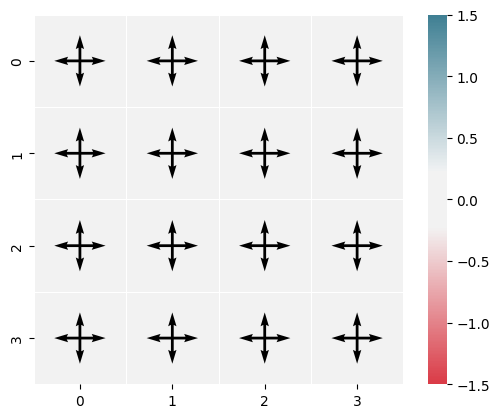

In [232]:
action_set = game.get_action_set()
plot_policy(V, Pi, action_set)

<font color="blue"><b>Comment:</b></font> Now that every state has the same probablity, it also falsly allows every state to move into every direction, even if they make no sense (e.g. the agent is in a state on the border of the GridWorld and obviously can't move in a direction outside of the border)
This will be fixed in the next step.

Ok great, we now have an explicit version of our random agent! The good news is that we can now update specific states and actions as we like. Next, let us make use of this new *feature* in order to improve our policy and make it more sane. The first thing we definetly want to improve is, to consider only reasonable moves, i.e. we want to ignore moves that will cause the agent walking into a wall etc.

### Building a world model

In the following you will build a world model using a map of the environment and the knowledge that you have. More precisely:

- consider only reasonable actions for the policy.
- implement $\mathcal{P}(s,a)$
- implement $\mathcal{R}(s,a,s')$

Here is the idea. The function `game.get_world_map()` will return you a plain version of the environment map without the player character. Since this map is a 2-dimensional array, you can query specific states of the map in the same way as we represent our states in the value function, i.e. with indices. For instance you can use this map to check if a specific state contains an "x" or "E" character etc. However, note that our value function is of shape $4 \times 4$ whereas the world map also contains the walls and is of shape $6 \times 6$. If you now loop over all value function indices (states) make sure your add (1,1) to it in order to translate to the corresponding world position. 

Next, check out the world map and try to query the "exit" square which is position `(0,3)` in state space. If you want, use the `ui.render` function to visualize the map.

In [233]:
world_map = game.get_world_map()


In [234]:
# Visualize the world map
print("World map \n",world_map)

World map 
 [[ 35  35  35  35  35  35]
 [ 35  32  32  32  69  35]
 [ 35  32 120  32  32  35]
 [ 35  32  32 120  32  35]
 [ 35  32  32  32  32  35]
 [ 35  35  35  35  35  35]]


In [235]:
ui.render(world_map, "COLOR")

We can now use this idea to limit the action set for a specific state to more reasonable actions, e.g. ignore those actions that will just walk us into a wall. To do so we can take a specific world position, add the value of an action to this tuple and check if the world map contains a wall character at the new position. The function `game.allowed_actions` does exactly this. It takes a *world position* in the form of a *tuple* and will return a reduced action set for that state.

Now use this function to create a more sane initial random policy. Distribute the probabilities equally across all allowed actions and set all other actions to zero. Remember that the action keys are `0,1,2,3,4` which corresponds to the their index in the policy array. Here is some initial code you can complete. Print and plot the policy afterwards.

In [236]:
""" 
def random_policy():
    
    Pi = np.zeros((game.state_space[0], game.state_space[1], game.action_space))
    num_rows, num_cols, num_actions = Pi.shape   
   
    for row in range(num_rows):
        for col in range(num_cols):
            # Translate state space index to world position
            world_row, world_col = row + 1, col + 1
            world_pos = (world_row, world_col)

            # Get the allowed actions for a distinct state
            allowed_actions = game.allowed_actions(world_pos)

            # Set a fitting probability for the allowed actions
            equal_probability = 1 / len(allowed_actions)
            for action in range(num_actions):
                Pi[row, col, action] = equal_probability if action in allowed_actions else 0

    return Pi

"""

' \ndef random_policy():\n    \n    Pi = np.zeros((game.state_space[0], game.state_space[1], game.action_space))\n    num_rows, num_cols, num_actions = Pi.shape   \n   \n    for row in range(num_rows):\n        for col in range(num_cols):\n            # Translate state space index to world position\n            world_row, world_col = row + 1, col + 1\n            world_pos = (world_row, world_col)\n\n            # Get the allowed actions for a distinct state\n            allowed_actions = game.allowed_actions(world_pos)\n\n            # Set a fitting probability for the allowed actions\n            equal_probability = 1 / len(allowed_actions)\n            for action in range(num_actions):\n                Pi[row, col, action] = equal_probability if action in allowed_actions else 0\n\n    return Pi\n\n'

In [237]:
def random_policy():

    game_x, game_y = len(game.get_world_map())-2, len(game.get_world_map()[0])-2  # -2 because of borders
    Pi = np.zeros((game_x,game_y,5))
    num_rows, num_cols, num_actions = Pi.shape
    
    for row in range(num_rows):
        for col in range(num_cols):
            # 1. Get the allowed actions for a distinct state
            allowed_actions = game.allowed_actions((row+1, col+1)).keys()

            # 2. Set a fitting probability for the allowed actions
            for allowed_action in allowed_actions:
                Pi[row, col, allowed_action] = 1/len(allowed_actions)

    return Pi

In [238]:
# Create and print the random policy
Pi = random_policy()
print(Pi)

[[[0.         0.33333333 0.         0.33333333 0.33333333]
  [0.         0.25       0.25       0.25       0.25      ]
  [0.         0.25       0.25       0.25       0.25      ]
  [0.         0.         0.         0.         1.        ]]

 [[0.25       0.25       0.         0.25       0.25      ]
  [0.2        0.2        0.2        0.2        0.2       ]
  [0.2        0.2        0.2        0.2        0.2       ]
  [0.25       0.25       0.25       0.         0.25      ]]

 [[0.25       0.25       0.         0.25       0.25      ]
  [0.2        0.2        0.2        0.2        0.2       ]
  [0.2        0.2        0.2        0.2        0.2       ]
  [0.25       0.25       0.25       0.         0.25      ]]

 [[0.33333333 0.         0.         0.33333333 0.33333333]
  [0.25       0.         0.25       0.25       0.25      ]
  [0.25       0.         0.25       0.25       0.25      ]
  [0.33333333 0.         0.33333333 0.         0.33333333]]]


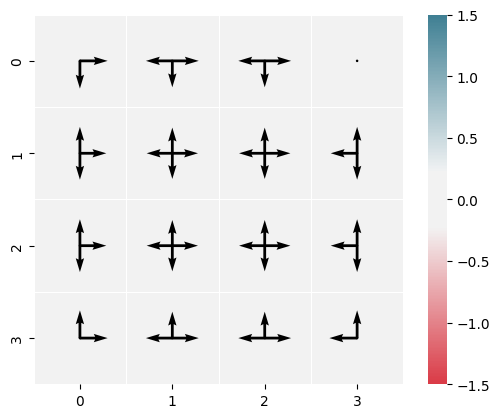

In [239]:
plot_policy(V, Pi, action_set)

Next, let us implement the **state transition function** $\mathcal{P}(s,a)$. For clarity, we will just call it `get_next_state`. Since our environment is deterministic, going from one state to another can be calculated by simply adding an action to a state tuple and return the resulting next state indices. 

Note that this state transition fully operates in value function space so performing an action `(-1,0)` in state `(0,0)` would result in a next state `(-1,0)` which is not *allowed*! However, since we will consider only allowed actions in our policy, you don't have to check for this case again. Just keep it very simple here.

But Beware! There is **one** important exception to this. Note that the exit square is a terminal state and that we have to reset the game from there. To model this correctly, make sure to return the starting position as the "next state" for the terminal state.

In [240]:
"""
def get_next_state(state, action):

    # Add the next action to the state tuple to get the next state 
    next_state = (state[0] + action[0], state[1] + action[1])

    # check if the next state is the terminal state (exit square)
    terminal_state = (0,3)

    if next_state == terminal_state:
        starting_position = (3,0)
        next_state = starting_position
    
    return next_state
"""

'\ndef get_next_state(state, action):\n\n    # Add the next action to the state tuple to get the next state \n    next_state = (state[0] + action[0], state[1] + action[1])\n\n    # check if the next state is the terminal state (exit square)\n    terminal_state = (0,3)\n\n    if next_state == terminal_state:\n        starting_position = (3,0)\n        next_state = starting_position\n    \n    return next_state\n'

In [241]:
def get_next_state(state, action, finish_char="E"):
    exit_x, exit_y = np.where(game.get_world_map() == ord(finish_char))

    # Determine player start position
    world_sizes = {6: 0, 10: 1, 22: 2}  # Needed to be hardcoded because there is no other option to get the world size from a running game
    obs, _, _ = exitgames.make_game(level=world_sizes[len(game.get_world_map())]).its_showtime()
    start_pos = np.array((np.where(obs.layers["P"])[0][0]-1, np.where(obs.layers["P"])[1][0]-1))

    next_state = np.add(state, action)
    
    if np.array_equal(state, np.array((exit_x[0]-1, exit_y[0]-1))):
        return start_pos
    
    return next_state

In [242]:
# Testing cell
print(get_next_state((2, 0), (0, 1)))
print(get_next_state((1, 3), (-1, 0)))


[2 1]
[0 3]


Finally we have to implement the **reward function** $R(s,a,s')$. Again, we will just call it `get_reward`. Since our environment is also deterministic for rewards, this function boils down to a simple lookup on the world map and should return a corresponding reward value. In general the reward may depend on the full triple $(s,a,s')$ but in our case it doesn't matter from which state we are coming or which action we have performed last. The only thing we care is the reward value for *being* in a distinct state $s$.

> Hint: you can use `ord()` to translate unicode characters to their integer code point value or `chr()` for the inverse.

In [243]:
""" 
def get_reward(state, world_map):
    # Translate the value function state to the corresponding world map position
    world_map_pos = (state[0] + 1, state[1] + 1)

    # Get the character at the world map position
    character = world_map[world_map_pos]

    # Check the character and return the corresponding reward value
    # 'x' is a wall, 'E' is the exit, ' ' is an empty space
    reward_mapping = {ord('x'):-1, ord('E'): 1, ord(' '): 0}

    # Get the rewarf for the given character, default is 0 if character is not in the mapping
    reward = reward_mapping.get(character, 0)

    return reward
"""

" \ndef get_reward(state, world_map):\n    # Translate the value function state to the corresponding world map position\n    world_map_pos = (state[0] + 1, state[1] + 1)\n\n    # Get the character at the world map position\n    character = world_map[world_map_pos]\n\n    # Check the character and return the corresponding reward value\n    # 'x' is a wall, 'E' is the exit, ' ' is an empty space\n    reward_mapping = {ord('x'):-1, ord('E'): 1, ord(' '): 0}\n\n    # Get the rewarf for the given character, default is 0 if character is not in the mapping\n    reward = reward_mapping.get(character, 0)\n\n    return reward\n"

In [244]:
def get_reward(state, world_map):
    reward_lookup = {"E": 1, "x": -1, " ": 0}
    chr_world_map = np.vectorize(chr)(world_map) # Convert map to character
    
    # Return reward value according to lookup table
    return reward_lookup[chr_world_map[state[0]+1, state[1]+1]]

In [245]:
# Testing cell
print('test trap cell' , get_reward((1,1), game.get_world_map()))
print('test empty cell' , get_reward((2,3), game.get_world_map()))
print('test exit cell' , get_reward((0,3), game.get_world_map()))

test trap cell -1
test empty cell 0
test exit cell 1


### Policy Evaluation

Great, now we have everything in place! In the remainder of this notebook you will finally implement an actual solution method called **Policy Iteration**. Policy Iteration consist of two parts. First, we will use **policy evaluation** to estimate the value of a given policy. Second we will use **policy improvement** to update our policy towards a better policy. Evaluating and improving a policy over and over will finally converge to a so called **optimal policy** $\pi_*$ which is defined as a policy that is better or equal to all other policies. In consequence, all optimal policies will produce (or share) the same **optimal state-value function** $v_*(s) = \displaystyle \max_\pi v_{\pi}(s)$. In reverse, if we can find an optimal value function we can derive an optimal policy by simply acting greedy with respect to the value function, i.e. by picking the states and actions with the highest values.

Now recap that with *better*, we mean a policy that will produce more reward in the long-run which we called **return**. Formally, we consider the *discounted return*,

$$\begin{eqnarray} 
G_t &=& R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots = \displaystyle \sum_{k=0}^{\infty}\gamma^k R_{t+k+1} \\
    &=& R_{t+1} + \gamma G_{t+1}
\end{eqnarray} $$

where $\gamma$ is the *discount rate* $0 \leq \gamma \leq 1$ and determines the importance of short term vs. long term reward. We will set $\gamma = 0.9$ from this point on. Note that by recursion we can write the return as the immediate reward plus the discounted return at timestep $t+1$. Next recap that the value function $V$ estimates the expected return when starting in a state $s$ and following policy $\pi$ thereafter, formally

$$V_{\pi}(s) = \mathbb{E}_{\pi} \Big[G_t \mid S_t = s\Big], \text{for all } s \in \mathcal{S}$$

By the same recursive relationship we can unroll the equation as follows,

$$\begin{eqnarray} 
V_{\pi}(s) &=& \mathbb{E}_{\pi} \Big[G_t \mid S_t = s\Big] \\
           &=& \mathbb{E}_{\pi} \Big[R_{t+1} + \gamma G_{t+1} \mid S_t = s \Big] \\
           &=& \mathbb{E}_{\pi} \Big[R_{t+1} + \gamma V_{\pi}(S_{t+1}) \mid S_t = s \Big] \\
\end{eqnarray}$$

In words, the value function of state $s$ is the expected immediate reward plus the discounted value of the expected next state. The tricky part of the equation is the expectation $\mathbb{E}$ which accounts for the potential stochastic policy and environent dynamics. In order to calculate $V(s)$ we have to sum over all actions that may be taken under a certain policy (the first sum below) and then sum over the distribution of rewards and next state values that the environment may produce (the second sum below). Formally, 

$$\begin{eqnarray} 
V_{\pi}(s) &=& \displaystyle \sum_a \pi(a\mid s) \sum_{s',r} p(s',r\mid s,a) \Big[r + \gamma V_{\pi}(s')\Big]
\end{eqnarray}$$

where $\pi(a \mid s)$ is the probability of taking action $a$ in state $s$ under policy $\pi$. We have stored this probability in our policy array. Furthermore we are solving a deterministic environment so the combined probability distribution $p(s',r \mid s,a)$, or the second sum, simplifies to a single case that will occur with probability 1. Since we have a model of the world we can get the values for $r$ and $s'$ by calling `get_reward` and `get_next_state` and the value for $V_{\pi}(s')$ by a simple table lookup in the current value function $V$. In summary, we can evaluate a policy by iteratively calculating 

$$\begin{eqnarray} 
V_{\pi}(s) &=& \displaystyle \sum_a \pi(a\mid s) \Big[\mathcal{R}(s) + \gamma V_{\pi}(\mathcal{P}(s,a))\Big]
\end{eqnarray}$$

for all states. This approach is called **iterative policy evaluation**. Now let us translate this into code.

### Policy Evaluation implementation

Here is a short checklist :)

1. Create a new value function `V_new` (that is all zero)
2. For every `state`
    - initialize a sum placeholder `v = 0`
    - translate the state to a world position
    - get the set of possible actions by calling `game.allowed_actions`
    - for every possible action
        - get the **probability** for taking the action from `Pi`
        - get the **reward** for the current state by calling `get_reward`
        - get the **next state** by calling `get_next_state`
        - calculate and add to partial `v` according to the equation above
    - set `V_new[state] = v`
3. Return the new value function

In [246]:

def evaluate_policy(V, Pi, gamma=0.9):
    
    # Get dims for new V from input V
    V_new = np.zeros((len(V), len(V[0])))

    for i, row in enumerate(V_new):
        for j, col in enumerate(row):
            v = 0
            allowed_actions = game.allowed_actions((i+1, j+1))
            
            # Get Probability, reward and next state for each action
            for action in allowed_actions:
                probability = Pi[i, j, action]
                reward = get_reward((i, j), game.get_world_map())
                next_state = get_next_state((i, j), game.get_action_set()[action])

                v += probability * (reward + gamma * V[next_state[0], next_state[1]])
            
            V_new[i, j] = v

    return V_new


In [247]:
Pi = random_policy()
V = np.zeros((game.state_space[0], game.state_space[1]))  # Get the state dims from the game obj
evaluate_policy(V=V, Pi=Pi)

array([[ 0.,  0.,  0.,  1.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.]])

- Below is a code snippet that will plot the value function and the policy next to each other. 
- Below that, is a code snipet that you can use to easily test your implementation (as long as you obeyed our naming conventions).

In [248]:
import matplotlib.pyplot as plt

def plot_things(Vi, Pi, action_set):
    plt.close()
    fig = plt.figure(figsize=(13,4.5))
    
    # plot value function left
    fig.add_subplot(1,2,1)
    plot_value_function(V)

    # plot policy right
    fig.add_subplot(1,2,2)
    plot_policy(V,Pi,action_set)

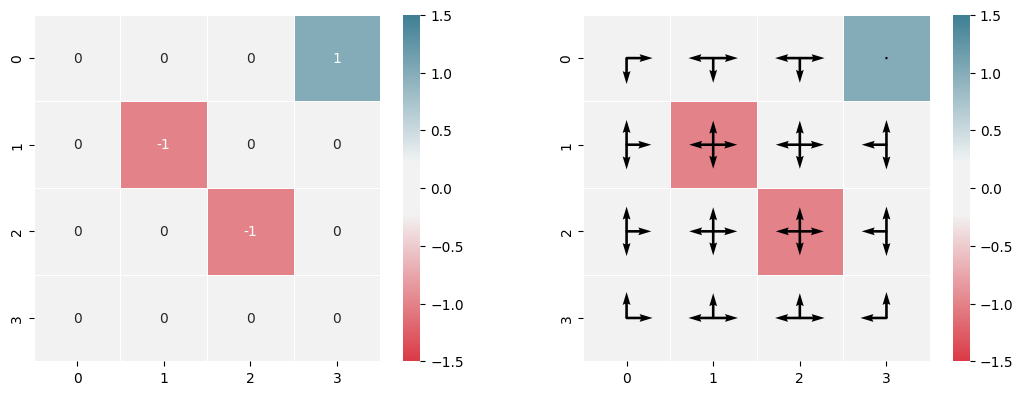

In [249]:
# initialize a clean value function , a random policy, gamma and get the action_set
V = np.zeros((4,4))
Pi = random_policy()
gamma = 0.9
action_set = game.get_action_set()

# evaluate the policy once and plot the result
V = evaluate_policy(V, Pi, gamma)
plot_things(V,Pi,action_set) 

If you feel comfortable that your implementation works here is another code snippet that lets you see the evaluation process over time. Try different variants for `n` to see the value function converge. Comment/Uncomment the display related code accordingly.

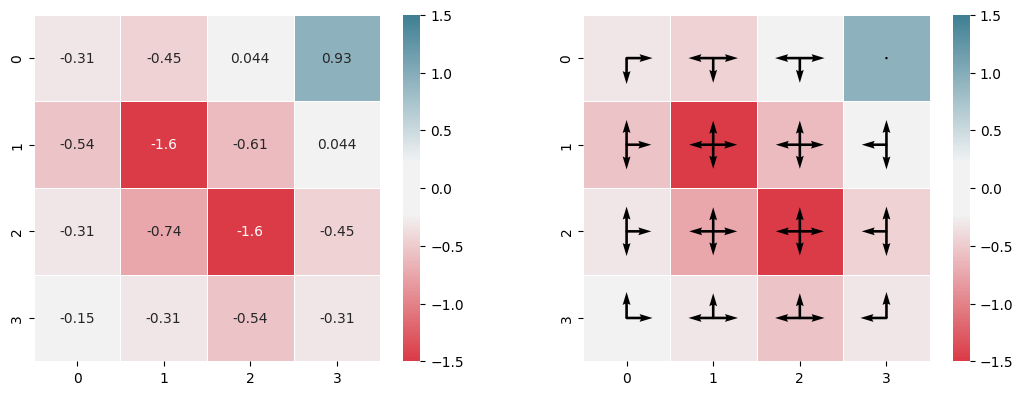

In [250]:
from IPython import display

# initialize a clean value function and random policy
V, Pi, gamma, action_set = np.zeros((4,4)), random_policy(), 0.9, game.get_action_set()

# evaluate the policy n times
for n in range(5):
    V = evaluate_policy(V, Pi, gamma)
    plot_things(V,Pi,action_set)
    plt.pause(0.3)
    display.clear_output(wait=True)

### Policy Improvement

Now that we can evaluate our policy, let's improve it based on the estimate of the action values function. We can do this by acting greedy w.r.t to the action values. In words, in every state we want to select those actions (from all possible actions) that appear best according to the **action-value function** $Q_{\pi}(s,a)$. Formally we want to retrieve a new *greedy* policy $\pi'$, give by

$$\begin{eqnarray} 
\pi'(s) &=& \arg \max_a Q_{\pi} \big(s,a\big) \\
        &=& \arg \max_a \mathbb{E} \Big[R_{t+1} + \gamma V_{\pi}(S_{t+1}) \mid S_t = s, A_t = a \Big] \\
        &=& \arg \max_a \displaystyle \sum_{s',r} p(s',r \mid s,a) \Big[r + \gamma V_{\pi}(s')\Big]                
\end{eqnarray}$$

which in our case can be calculated by

$$
\pi'(s) = \arg \max_a \displaystyle \Big[\mathcal{R}(s) + \gamma V_{\pi}(\mathcal{P}(s,a))\Big]
$$

This looks very similar to the calculation of the state-value function. However, **we now compare the outcome of every action separately** and select only the best one, i.e. the action that appears to return the most reward in the long run. If there is a single best action, the new greedy policy will *choose* that action with probability 1 in the future. If there are more than one equally *good* actions the probability mass should be distributed equally between them.

To make the difference more clear. We now ignore the probability under which some action $a$ was taken given some old policy $\pi$! Instead, we want to create a **new policy** $\pi'$ and we do this by selecting the most promising action **from all possible actions**. 


### Policy Improvement implementation

Again, use the code cells below to test your implementation.
Here is a short checklist :)

1. Create a new policy `Pi_new` (that is all zeros)
2. For every `state`
    - initialize a placeholder for the best value so far `q_max`
    - initialize an empty list `best_actions = []`
    - translate the state to a world position
    - get the set of possible actions by calling `game.allowed_actions`
    - for every possible action
        - get the **reward** for the current state by calling `get_reward`
        - get the **next state** by calling `get_next_state`
        - calculate `q(s,a)` according to the equation above
        - check if `q` is greater or equal to `q_max` and store the action accordingly in `best_actions`.   
    
    - distribute the new probabilities equally over all `best_actions`
    - assign zero probability to all other actions
3. Return the new policy

In [251]:
"""
def greedy_policy(V, gamma):
    world_map = game.get_world_map()
    num_actions = len(game.get_action_set())
    V_shape = V.shape
    Pi_new = np.zeros((*V_shape, num_actions))

    for row in range(V_shape[0]):
        for col in range(V_shape[1]):
            state = (row, col)
            world_pos = (row + 1, col + 1)
            allowed_actions = game.allowed_actions(world_pos)
            q_max = -np.inf
            best_actions = []

            for action_idx in allowed_actions:
                action = game.get_action_set()[action_idx]
                reward = get_reward(state, world_map)
                next_state = get_next_state(state, action)
                q = reward + gamma * V[next_state]

                if q > q_max:
                    q_max = q
                    best_actions = [action_idx]
                elif q == q_max:
                    best_actions.append(action_idx)

            prob = 1 / len(best_actions)
            for action_idx in best_actions:
                Pi_new[state][action_idx] = prob

    return Pi_new
    """

'\ndef greedy_policy(V, gamma):\n    world_map = game.get_world_map()\n    num_actions = len(game.get_action_set())\n    V_shape = V.shape\n    Pi_new = np.zeros((*V_shape, num_actions))\n\n    for row in range(V_shape[0]):\n        for col in range(V_shape[1]):\n            state = (row, col)\n            world_pos = (row + 1, col + 1)\n            allowed_actions = game.allowed_actions(world_pos)\n            q_max = -np.inf\n            best_actions = []\n\n            for action_idx in allowed_actions:\n                action = game.get_action_set()[action_idx]\n                reward = get_reward(state, world_map)\n                next_state = get_next_state(state, action)\n                q = reward + gamma * V[next_state]\n\n                if q > q_max:\n                    q_max = q\n                    best_actions = [action_idx]\n                elif q == q_max:\n                    best_actions.append(action_idx)\n\n            prob = 1 / len(best_actions)\n            for 

In [252]:
def greedy_policy(V, gamma= 0.9):
    
    game_x, game_y = len(game.get_world_map())-2, len(game.get_world_map()[0])-2  # -2 because of borders
    Pi_new = np.zeros((game_x, game_y, 5))
    
    # Iterate over every state
    for i, row in enumerate(V):
        for j, col in enumerate(row):            
            all_actions_q = np.full(5, -np.inf)
            allowed_actions = game.allowed_actions((i+1, j+1))
            
            # Calculate q for every action in current state
            for action in allowed_actions:
                reward = get_reward((i, j), game.get_world_map())
                next_state = get_next_state((i, j), game.get_action_set()[action])
                q = reward + gamma * V[next_state[0], next_state[1]]
                all_actions_q[action] = q
            
            # Determine best q value apply probabilites to Pi_new
            for k, action_q in enumerate(all_actions_q):
                if action_q == np.max(all_actions_q):
                    Pi_new[i, j, k] = 1/np.count_nonzero(all_actions_q == np.max(all_actions_q))
            
    return Pi_new

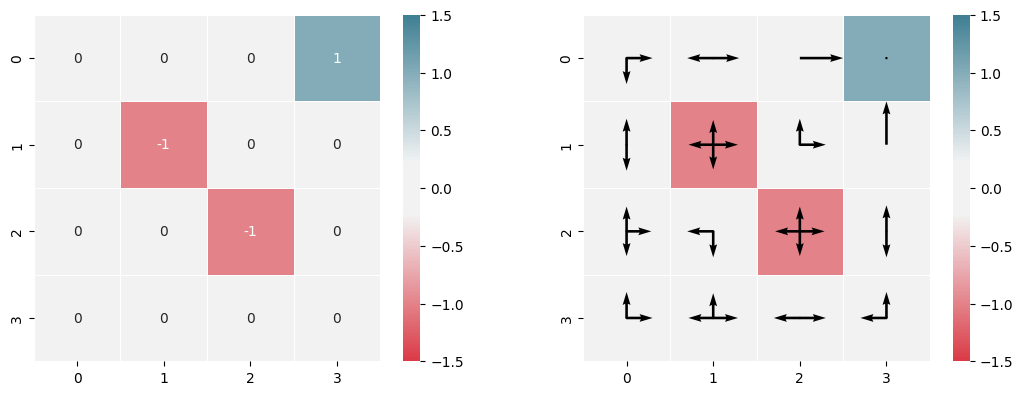

In [253]:
# initialize a clean value function and random policy
V, Pi, gamma, action_set = np.zeros((4,4)), random_policy(), 0.9, game.get_action_set()

# evaluate the policy once
V  = evaluate_policy(V, Pi, gamma)

# update the policy
Pi = greedy_policy(V, gamma)

# plot the value function and the updated policy
plot_things(V,Pi,action_set)

If your are convinced that your greedy policy is working, proceed to the next cell.

### Value Iteration

Cool. Now you can use iterative policy evaluation and greedy policy improvement in a loop to solve our little gridworld. In general, this algorithm is called **Policy Iteration**. Here are some completing questions:

- Do you think it is necessary for the value function to converge before you can apply a meaningful policy improvement?
- If not, how many evaluation steps do you think are enough for the algorithm to work?


Okay, these are intentionally very leading questions. There exists a popular special case of policy iteration in which the policy gets improved after **every** evaluation step. This variant is known as the **Value Iteration** algorithm. If you have sticked to our naming conventions, you can use the code below to run your implementation and watch your value function and policy converging over time. Some final remarks:

- Make sure you try different values for `k`.

- How many iterations does it take for the **policy** to converge?

<font color="blue"><b>Comment:</b></font> With default settings, The policy starts to stabilize after a relativly small number of Iterations. In GridWorld Level 0 this happens after 5 Iterations (Righthandside, the paths from finish to start doesn't change after the 5 iteration)
- Why do you think does it take exactly that many steps?

<font color="blue"><b>Comment:</b></font> Essentially it depends on the complexity of the environment. In our case, GridWorld Level 0 can be considered very simplistic and thus the policy converges in a few iteration.
It took exactly five iterations for the policy to converge, it means that after five iterations of updates, our policy didn't change anymore - the agent had found the best action to take in each state according to the current estimation of the state values.
Why could it take exactly 5 steps?

1. The agent starts with an initial policy (in our case, a random policy). The value of each state according to this policy is then calculated, leading to the first iteration.

2. Based on the updated values of each state, the agent improves the policy by choosing the action that appears best according to the current state-value function. This forms the second iteration.

3. This process repeats, and the value function gets better and better at each iteration, allowing for a better policy.

4. By the fifth iteration, the agent has enough information about the value of each state that changing the policy wouldn't change the expected return. At this point, the policy has converged

- To print all iterations, outcomment the `display.clear_output` call.

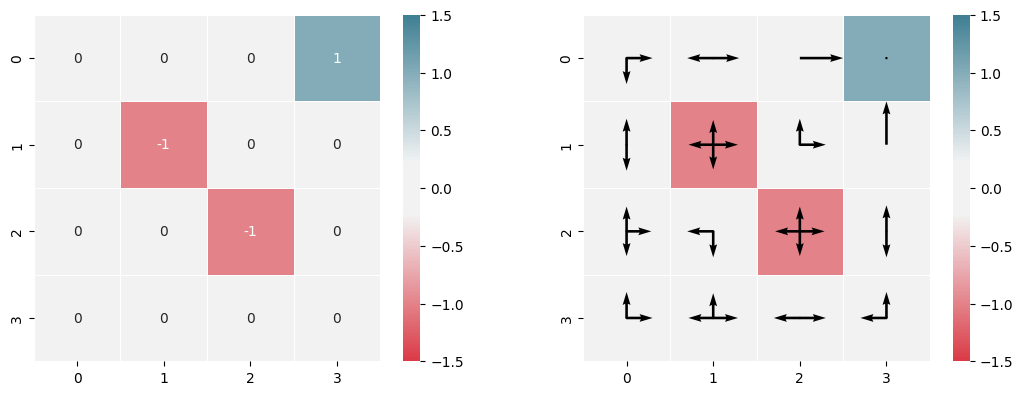

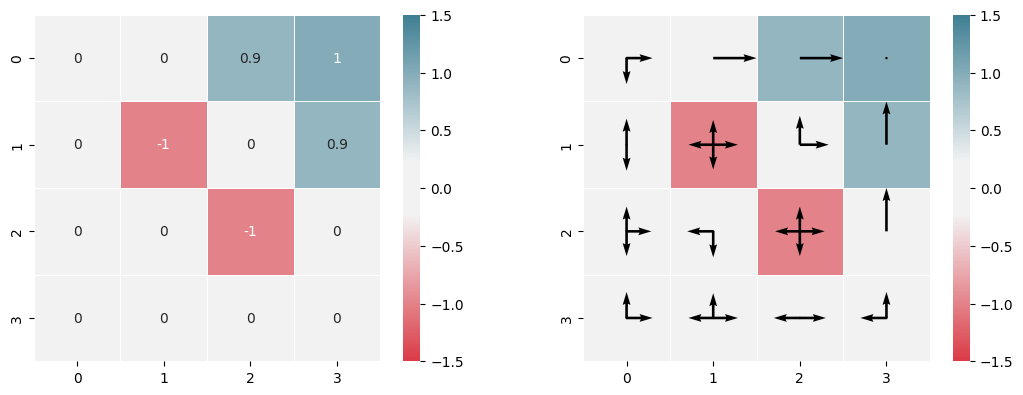

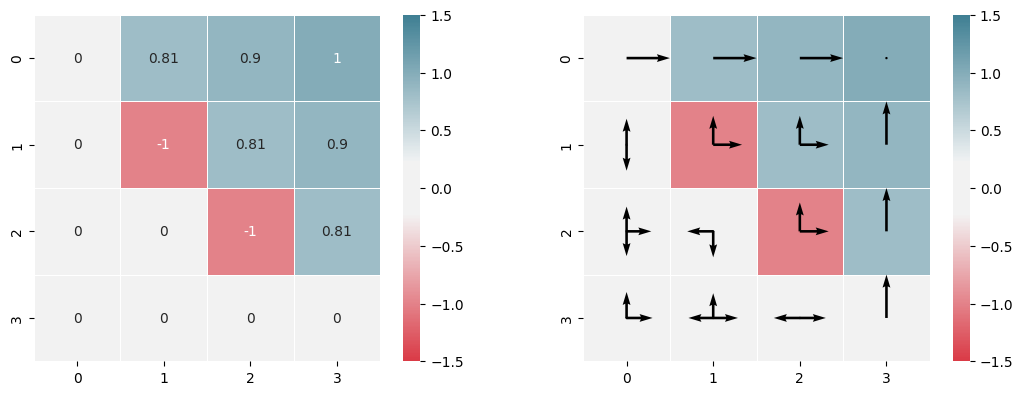

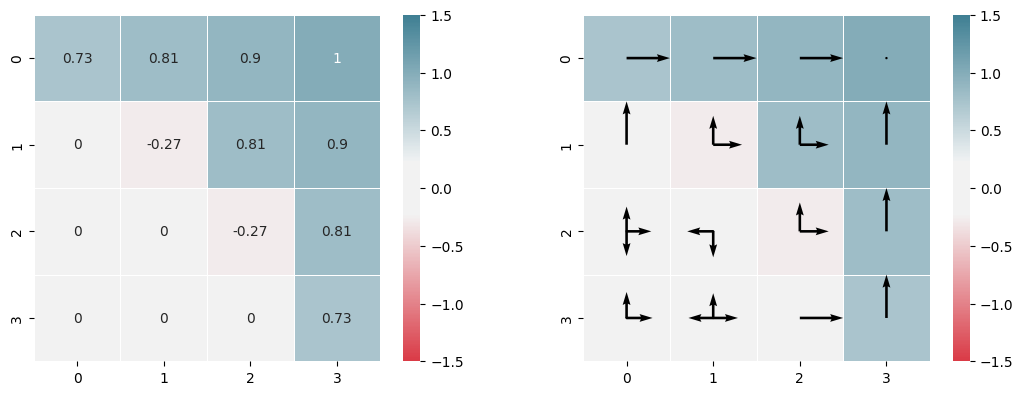

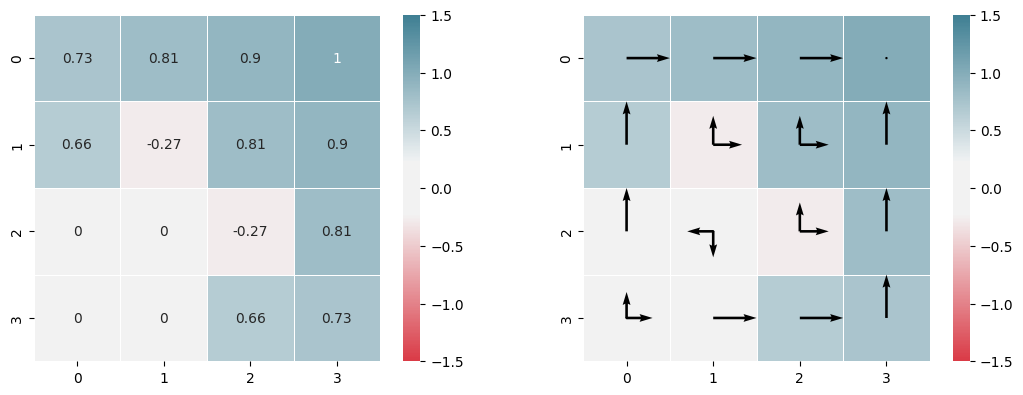

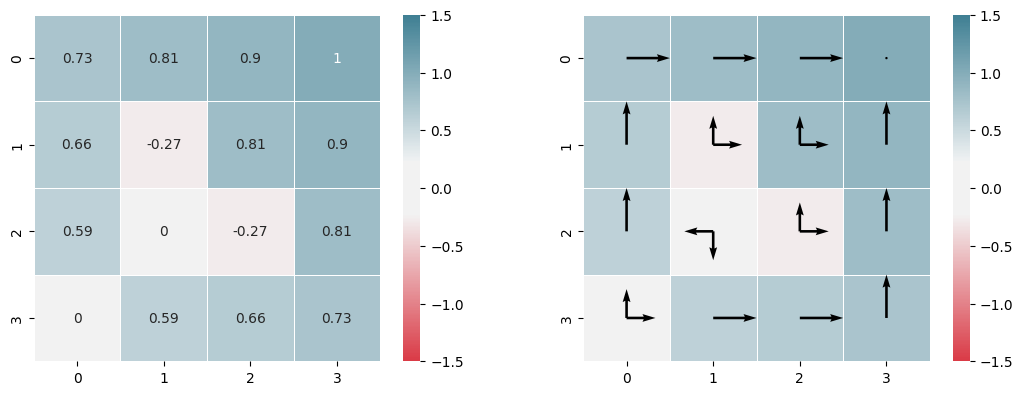

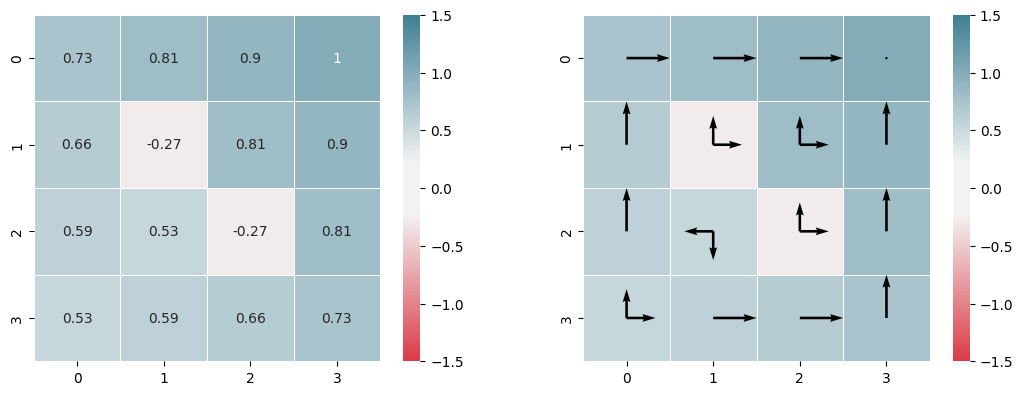

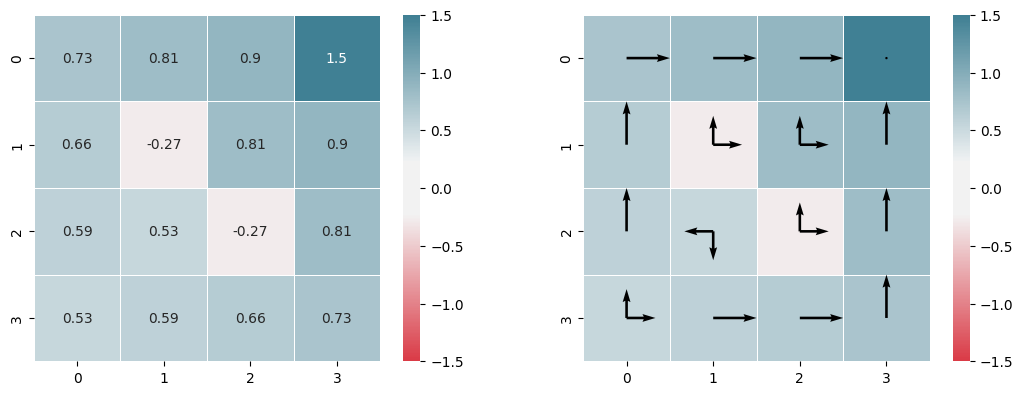

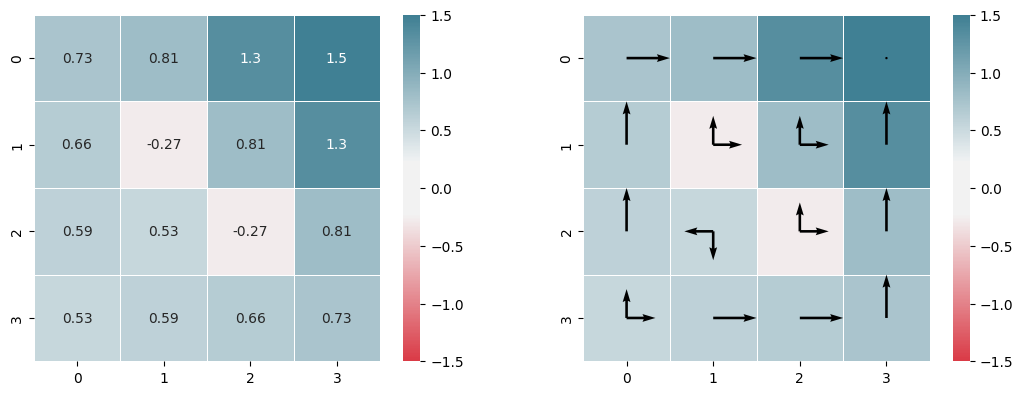

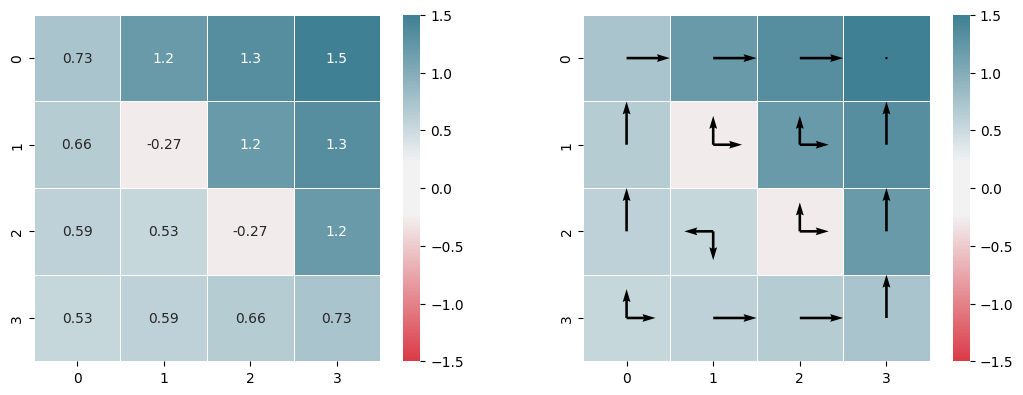

In [254]:
# initialize a clean value function and a random policy
V, Pi, gamma, action_set = np.zeros((4,4)), random_policy(), 0.9, game.get_action_set()

# run the policy iteration algorithm for k steps
for k in range(10):
    
    # evaluate the policy n times, n=1 is called value iteration
    for n in range(1):
        V = evaluate_policy(V, Pi, gamma)
    
    # greedily improve the policy
    Pi = greedy_policy(V, gamma)
    
    # plot the evaluated value function and the updated policy
    plot_things(V,Pi,action_set)
    plt.pause(0.3)
    #display.clear_output(wait=True)

## Further Ideas

Mandatory:
- See task list from **Value Iteration** and write down your thoughts.

Optionally: (only if good in time, if not, better start with the next notebook)

- Experiment with different settings. 
- Experiment with exitgames level 1.

## Next: PIA - Reinforcement Learning: 3. Tabular Q-Learning

In [133]:
def run_greedy_training(k_steps, n_eval_steps=1, gamma=0.9):
    global game, V, Pi
    
    # initialize a clean value function and a random policy
    game_x, game_y = len(game.get_world_map())-2, len(game.get_world_map()[0])-2  # -2 because of borders
    V, Pi = np.zeros((game_x, game_y)), random_policy() 
    action_set = game.get_action_set()

    # run the policy iteration algorithm for k steps
    for k in range(k_steps):

        # evaluate the policy n times, n=1 is called value iteration
        for n in range(n_eval_steps):
            V = evaluate_policy(V, Pi, gamma)

        # greedily improve the policy
        Pi = greedy_policy(V, gamma)

        # plot the evaluated value function and the updated policy
        plot_things(V,Pi,action_set)
        plt.pause(0.05)
        display.clear_output(wait=True)

In [134]:
game, ui = exitgames.make_game(level=1), exitgames.get_notebook_ui()
ui.render(game.its_showtime()[0], "COLOR")

In [135]:
run_greedy_training(k_steps=200, n_eval_steps=1, gamma=.99)

KeyboardInterrupt: 

TODO: Penalty für Laufen

In [ ]:
game, ui = exitgames.make_game(level=2), exitgames.get_notebook_ui()
ui.render(game.its_showtime()[0], "COLOR")

In [ ]:
run_greedy_training(k_steps=500, n_eval_steps=1, gamma=.99)

KeyboardInterrupt: 